Authors: Tim Gorman, Yu Cao, Ling Zhou

---

Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe.

In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# from googletrans import Translator, constants
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

import langdetect
from langdetect import detect

# Note: To install geopandas, open a terminal in jupyter and run the following commands

# pip install pipwin 
# pipwin install gdal 
# pipwin install fiona 
# pip install geopandas

# Exploring `train.csv`

## Basic information

The official description from [Kaggle](https://www.kaggle.com/competitions/foursquare-location-matching/data):

This set comprises eleven attribute fields for over one million place entries, together with:    
 * `id` - A unique identifier for each entry.  
 * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI.
 
 This data set is large (1138812 entries). Later we will decide only work with the file `pairs.csv` for our modeling.

In [2]:
# loading data
df_train = pd.read_csv("../data_raw/train.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [4]:
df_train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [5]:
df_train.shape

(1138812, 13)

## Missing values
- No missing values in the features: `id`, `latitude`, `longitude`, `point_of_interest`(POI)
- All other features have missing values
- Features with most missing values (top 3): `url`, `phone`, `zip`.
- only one missing value in `name`

id                    0.000000
latitude              0.000000
longitude             0.000000
point_of_interest     0.000000
name                  0.000088
country               0.000966
categories            8.632417
city                 26.272027
address              34.827610
state                36.931996
zip                  52.284837
phone                69.893626
url                  76.490940
dtype: float64


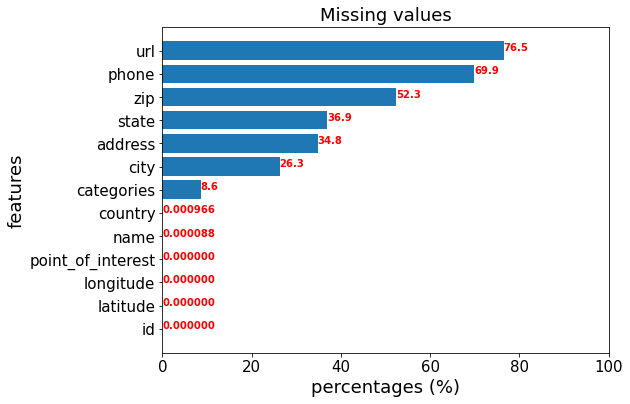

In [6]:
df = df_train.copy()
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
# ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Features in `train.csv`

- We verify that the `id` feature is indeed a unique identifier for each entry.

- We explore in this section the features that have fewer missing values:
    - latitude and longitude
    - name
    - country
    - point_of_interest

- We explore entries that have the same POI.

In [7]:
print(df.columns.values)

['id' 'name' 'latitude' 'longitude' 'address' 'city' 'state' 'zip'
 'country' 'url' 'phone' 'categories' 'point_of_interest']


### `id` (no missing values)

In [8]:
# each value in `id` is indeed unique.
print("Each value in `id` is unique:", len(df.id.unique()) == df.shape[0])

Each value in `id` is unique: True


### `latitude` and `longitude` (no missing values)
This (combination of) feature(s) shows that the places are all over the world, mostly in the US and the European regions.


In [9]:
# # fancy plot
# geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
# gdf = GeoDataFrame(df_train.copy(), geometry=geometry)   

# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# fig, ax = plt.subplots(figsize=(20, 12))
# world.plot(figsize=(20, 12), ax=ax)
# gdf.plot(ax=ax, marker='o', color='red', markersize=10)

# fig.savefig("./train_coords.png")
# plt.show()

### `name`

This column has different languages. 

#### How many languages are present in `name`?

We sample 10K names and find that roughly 20% of the sampled data is in English. The second most frequent language is about less than 8%.

In [15]:
def lang_detect(x):
    ''' language detect with exception handling '''
    
    try:
        return detect(x)
    except:
        # print names that cause exception.
        print(x,end=' ')
        return np.nan

df = df_train.copy()
tmp = df['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'',regex=True).str.lower()
lang_sample = tmp.apply(lang_detect)

366 bagh🌳🐝🐞🐜🐛🍀🌱🌿🌷🌾🍃 152💔🚶🏻 ｇｕｃｃｉ 

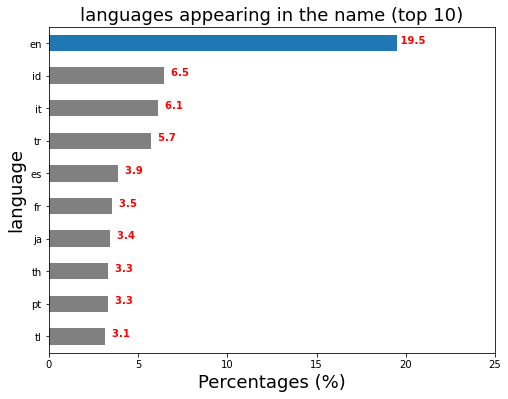

In [16]:
lang_stats = lang_sample.value_counts()*100/lang_sample.value_counts().sum()
lang_stats = lang_stats.head(10).sort_values()

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(lang_stats.index)
color[-1] = '#1f77b4'
lang_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("languages appearing in the name (top 10)", fontsize = 18)
ax.set_ylabel('language', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(lang_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,25)
plt.show()

### `country` 

Data availability in the `country` feature.


(10,)


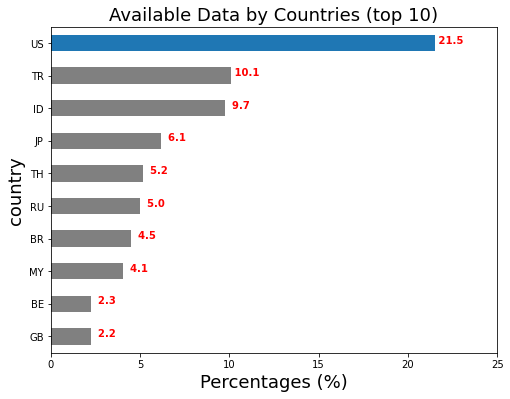

In [18]:
df = df_train.copy()
country_stats = df['country'].value_counts()*100/df['country'].value_counts().sum()
country_stats = country_stats.head(10).sort_values()
print(country_stats.shape)

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(country_stats.index)
color[-1] = '#1f77b4'
country_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("Available Data by Countries (top 10)", fontsize = 18)
ax.set_ylabel('country', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(country_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,25)
plt.show()

### `point_of_interest`

Notes on the `point_of_interest` feature:
https://www.kaggle.com/competitions/foursquare-location-matching/discussion/318967#1783581

In [19]:
print('There are {} distinct POIs.'.format(df.point_of_interest.nunique()))
print('Abount {:.2f} %POIs are uniue'.format(df.point_of_interest.nunique()*100/df.point_of_interest.shape[0]))

There are 739972 distinct POIs.
Abount 64.98 %POIs are uniue


In [20]:
most_freq_POI = df['point_of_interest'].value_counts().head(10)
most_freq_POI

P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
P_59cb47cbf3a432    130
P_f82d146eaf21da    120
P_40323f7f948c18    120
P_f8a0cd160eec80    119
P_6c385e5fd3a4b7    119
Name: point_of_interest, dtype: int64

In [21]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[0]].sort_values(by='name')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
89407,E_140b5041aa4cd6,"""\""Sorkarno - Hatta Intl Airport, Indonesia\""""",-6.122573,106.725217,Jl Raya Bandara,Tangerang,Indonesia,NaN,ID,NaN,NaN,Airports,P_fb339198a31db3
1115855,E_fadb459e7f70ca,(CGK) Soekarno Hatta International Airport,-6.317134,106.805808,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
545547,E_7a97df0189d838,@ Blue Bird Otw To Soeta,-6.229253,106.587979,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3
1086887,E_f43a547c2bf278,@ Jakarta International Airport Soekarno Hatta,-6.188795,106.814735,"Tangerang, Banten",NaN,NaN,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3
703170,E_9def7e6622aff9,Airport,-6.226321,106.610071,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3


In [22]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[4]].sort_values(by='name')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1113750,E_fa600b778ee5b6,15 TEMMUZ ŞEHİRLER KÖPRÜSÜ Boğaziçi,41.053444,29.025681,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_fbe61733fcdebe
205220,E_2e0eabcf4f1fce,15 TEMMUZ ŞEHİTLER KÖPRÜSÜ,41.044080,29.035778,ÜSKÜDAR,İSTANBUL,İstanbul,34600,TR,NaN,NaN,Toll Plazas,P_fbe61733fcdebe
1113170,E_fa3f089d94ab18,15 TEMMUZ ŞEHİTLER KÖPRÜSÜ,41.066280,29.109200,15 TEMMUZ ŞEHİTLER KÖPRÜSÜ,İSTANBUL,İstanbul,34830,TR,NaN,NaN,Bus Stops,P_fbe61733fcdebe
836015,E_bbb9eece6631b4,15 Temmuz Şehitler Köprüsü,41.045662,29.033861,NaN,İstanbul,İstanbul,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe
817814,E_b7a8576db9ee44,15 Temmuz Şehitler Köprüsü,41.045322,29.034568,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe


In [23]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[3]].sort_values(by='name')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
439624,E_62cd73485781f1,Demir Tekel,41.041172,29.027612,Ambarli Mh. Cumhuriyet Cd No 17 A,Avcilar,Istanbul,NaN,TR,NaN,NaN,"Smoke Shops, Convenience Stores",P_9290e406eb58ac
278777,E_3e948439e48f45,FutureIsNow@Ciftci Tekel Bayii,41.007343,28.965347,Mimar Kemalettin Mahallesi Mithatpasa Caddesi ...,Istanbul,NaN,NaN,TR,NaN,NaN,Smoke Shops,P_9290e406eb58ac
315654,E_46ef95847e0610,FutureIsNow@Gunes Bufe,41.009254,28.964443,Mimar Kemalettin Mahallesi Darphane Sokak No:2...,Istanbul,NaN,NaN,TR,NaN,NaN,Convenience Stores,P_9290e406eb58ac
793420,E_b2346f54a52976,FutureIsNow@Mini Market,41.004417,28.975771,NaN,NaN,NaN,NaN,TR,NaN,NaN,Convenience Stores,P_9290e406eb58ac
902887,E_cacdf23280dc06,FutureIsNow@Rut 24 Tekel,40.951267,29.098049,Bostancı Mah. Bagdat Cad. No544 Kadiköy,Istanbul,NaN,NaN,TR,NaN,NaN,Convenience Stores,P_9290e406eb58ac


# Exploring the US data in `train.csv`

In [24]:
df_us = df[df['country']=='US'].copy()

In [25]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


## Missing values
- No missing values in the features: `id`, `latitude`, `longitude`, `point_of_interest`(POI)
- All other features have missing values
- Features with most missing values (top 3): `url`, `phone`, `address`.
- only one missing value in `name`

id                    0.000000
latitude              0.000000
longitude             0.000000
country               0.000000
point_of_interest     0.000000
name                  0.000408
state                 2.409860
city                  3.686747
categories            5.361540
zip                  13.048955
address              23.018216
phone                46.349130
url                  59.444155
dtype: float64


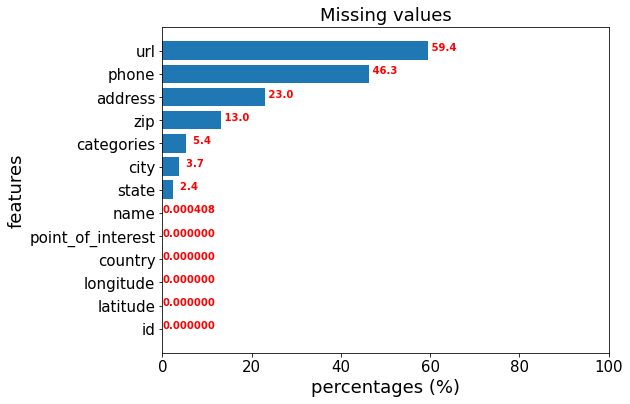

In [26]:
df = df_us.copy()
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
# ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Features

### `latitude` and `longitude`

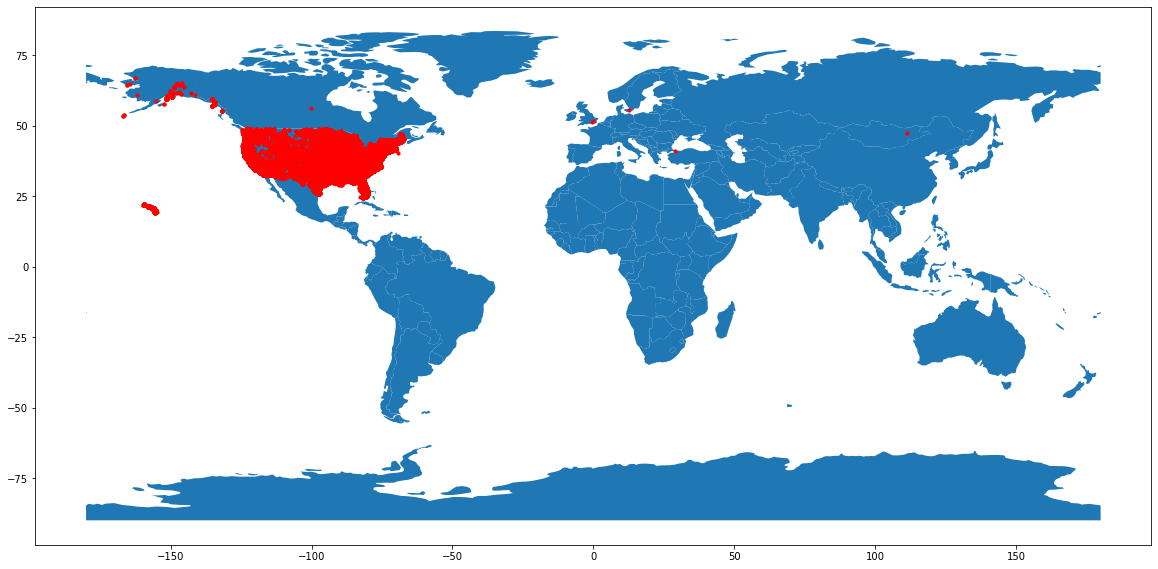

In [27]:
# fancy plot
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(figsize=(20, 12), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=10)

fig.savefig("./train_coords_us.png")
plt.show()

# fig, ax = plt.subplots(figsize=(40,10))
# ax.scatter(df_us['longitude'],df_us['latitude'])
# ax.set_xlabel('longitude',fontsize=40)
# ax.set_ylabel('latitude',fontsize=40)
# ax.tick_params(axis='both', labelsize=40)
# ax.set_title('US data',fontsize=40)
# ax.grid()
# plt.show()

### `name`

In [29]:
tmp = df_us['name'].sort_values()
tmp

622268                               "#208 \"Comfort Inn\""
769105                  "Access Health Care, LLC \"Adams\""
885613                 "Access Health Care, LLC \"Howell\""
779271    "Alfredo's Beach Club's \"Sunsets On The Beach...
493745                       "AmVets Post #2 \"Post Home\""
                                ...                        
150203                                   Kaleigh's Krib
513853                                              Heaven
121260                                  ﻿V Bar Ultra Lounge
474973                                   💇 Hair By CHiiNK 💋
750648                                                  NaN
Name: name, Length: 245284, dtype: object

In [28]:
def lang_detect(x):
    ''' language detect with exception handling '''
    
    try:
        return detect(x)
    except:
        # print names that cause exception.
        print(x,end=' ')
        return np.nan

tmp = df['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'',regex=True).str.lower()
lang_sample = tmp.apply(lang_detect)

711 711 

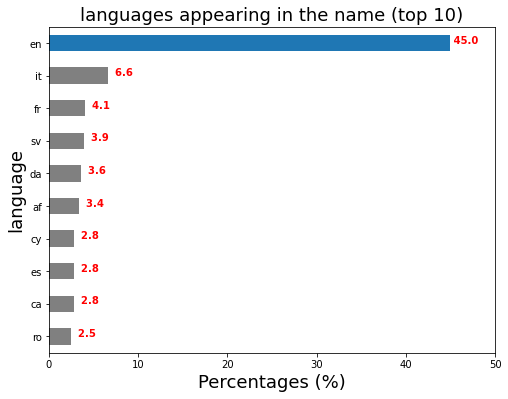

In [30]:
lang_stats = lang_sample.value_counts()*100/lang_sample.value_counts().sum()
lang_stats = lang_stats.head(10).sort_values()

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(lang_stats.index)
color[-1] = '#1f77b4'
lang_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("languages appearing in the name (top 10)", fontsize = 18)
ax.set_ylabel('language', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
for index, value in enumerate(lang_stats.values):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'red', fontweight = 'bold')
ax.set_xlim(0,50)
plt.show()

### `state`

- We can filter non US data by looking at the `state` feature. 
- It turns out that the state codes are not in the same format. 

In [31]:
df_us['state'].unique()

array(['CA', 'GA', 'NM', 'FL', 'PA', 'VA', 'NJ', 'OH', 'WI', 'MO', 'SC',
       'TN', 'OR', 'AZ', 'TX', 'MD', 'NY', 'MI', 'MA', 'NC', 'UT', 'IN',
       'IL', nan, 'Calif', 'NV', 'KS', 'MS', 'WA', 'AL', 'OK', 'AR', 'CT',
       'KY', 'NE', 'WV', 'CO', 'HI', 'ID', 'LA', 'MN', 'MT', 'ME', 'NH',
       'nv', 'WY', 'IA', 'DE', 'RI', 'VT', 'il', 'ND', 'AK', 'DC', 'SD',
       'D.C.', 'Ia', 'Ohio', 'Nj', 'Georgia', 'Nc', 'de', 'New York',
       'New Jersey', 'Ca', 'texas', 'Pa', 'Missouri', 'pa', 'Tx',
       'Connecticut', 'Ok', 'co', 'wi', 'Va', 'Az', 'ca',
       'North Carolina', 'Tennessee', 'Pennsylvania', 'Florida',
       'Massachusetts', 'tx', 'Kansas', 'Ny', 'Ga', 'Virginia', 'fl',
       'Tamaulipas', 'LOUISIANA', 'nc', 'Il', 'California', 'Ma', 'PR',
       'wa', 'Maryland', 'ny', 'Illinois', 'District of Columbia', 'Iowa',
       'Texas', 'CE', 'Wisconsin', 'Fl', 'mi', 'az', 'Arkansas',
       'Capital Region of Denmark', 'Minnesota', 'Md', 'Tn',
       'Mississippi', 'Idaho', 

In [32]:
# # Drop these.
# filter_set = ['国外','UK','CE','ON/NY','Capital Region of Denmark','BCN','Tamaulipas','NU']
# df_us[df_us['state'].isin(filter_set)]

### `categories`

In [49]:
df_us.loc[df_us['categories'].notna(),'categories'].sort_values()

1060532                                                 ATMs
464577                                                  ATMs
549309                                                  ATMs
450405                                                  ATMs
630674                                                  ATMs
                                 ...                        
928084                        Zoos, Playgrounds, Theme Parks
23377      Zoos, Residential Buildings (Apartments / Cond...
509463                                     Zoos, Theme Parks
592928               Zoos, Theme Parks, Other Great Outdoors
1017048                                   Zoos, Zoo Exhibits
Name: categories, Length: 232133, dtype: object

### `point_of_interest`

In [51]:
df = df_us.copy()
print('There are {} distinct POIs.'.format(df.point_of_interest.nunique()))
print('Abount {:.2f} %POIs are uniue'.format(df.point_of_interest.nunique()*100/df.point_of_interest.shape[0]))

There are 160641 distinct POIs.
Abount 65.49 %POIs are uniue


In [52]:
most_freq_POI = df['point_of_interest'].value_counts().head(10)
most_freq_POI

P_399ab9d64f2a2e    58
P_ce9291000a8f0b    46
P_a3fddc2f0a77e7    37
P_d89437d5f1169c    35
P_5cf56bf7bdf7ae    29
P_fff25ec89e22da    28
P_0c880e80aaa19f    26
P_bae8584591fe1a    26
P_1e8e17b542e178    25
P_4efd9da6085caf    25
Name: point_of_interest, dtype: int64

In [53]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[0]].sort_values(by='name')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
642307,E_90630d60677c99,Gregg Steiner - Nationwide Insurance & Financi...,33.607341,-117.877248,3 Corporate Plaza Dr Ste 250,Newport Beach,CA,92660,US,http://t.co/4eDIQ4ptQn,+19492200701,Financial or Legal Services,P_399ab9d64f2a2e
268102,E_3c368427e1cb7d,James S Wills Agency - Nationwide Insurance,34.002130,-81.772107,100 North Main St,Saluda,SC,29138,US,http://agency.nationwide.com/agent/james-wills...,8644450011,NaN,P_399ab9d64f2a2e
1517,E_005b1a6f97ca7b,Nationwide Insurance,39.962014,-82.885847,583 S Yearling Rd,Columbus,OH,43213,US,http://t.co/4eDIQ4ptQn,+16145752643,Financial or Legal Services,P_399ab9d64f2a2e
585453,E_839a15bc569a8c,Nationwide Insurance,39.280624,-76.611005,209 Key Hwy,Baltimore,MD,21230,US,http://agency.nationwide.com/agent/lawrence-l-...,+14108376400,Financial or Legal Services,P_399ab9d64f2a2e
233839,E_347ba6490704f1,Nationwide Insurance,41.224360,-73.071814,333 Boston Post Rd,Milford,CT,06460,US,http://t.co/4eDIQ4ptQn,+12038789003,Financial or Legal Services,P_399ab9d64f2a2e


In [ ]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[1]].sort_values(by='name')
tmp.head()

In [54]:
tmp = df[df['point_of_interest']==most_freq_POI.keys().values[2]].sort_values(by='name')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
284681,E_3fe9cc909dac86,12 hour work day = lost voice,28.473537,-81.464653,NaN,Orlando,FL,32819,US,NaN,NaN,Coworking Spaces,P_a3fddc2f0a77e7
544544,E_7a616daa47e92b,@ Work,28.473057,-81.272141,NaN,Orlando,FL,32829,US,NaN,NaN,Fairs,P_a3fddc2f0a77e7
47999,E_0abd0b3f5f7fbb,@ work,28.588776,-81.416936,Parkway Commerce Blvd.,Orlando,FL,32808,US,NaN,NaN,NaN,P_a3fddc2f0a77e7
666911,E_95d3f005074fc8,Heading to work!,28.484512,-81.408905,NaN,Orlando,FL,32839,US,NaN,NaN,Bowling Alleys,P_a3fddc2f0a77e7
302839,E_4400f8dd22b9bf,Hell Aka Work,28.798779,-81.296295,132 commerce way,Sanford,FL,NaN,US,NaN,NaN,Tech Startups,P_a3fddc2f0a77e7


# Exploring and Manipulating `pairs.csv`

Official description of the data:

`pairs.csv` - A pregenerated set of pairs of place entries from train.csv designed to improve detection of matches. You may wish to generate additional pairs to improve your model's ability to discriminate POIs.
        
`match` - Whether (True or False) the pair of entries describes a common POI (in `train.csv`).

The file `pairs.csv` is a subset of pairs from `train.csv`. The value of `match` is "True" if an only if the pair has the same `point_of_interest` (POI) value in `train.csv`. We will focus on the US pairs. 


## Basic information

In [55]:
# # Tim loading
# df_pairs = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\data_raw\pairs.csv')
# Yu loading
df_pairs = pd.read_csv('../data_raw/pairs.csv')

In [56]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


In [64]:
print('There are {} pairs'.format(df_pairs.shape[0]))
print('There are {} unique id_1s'.format(df_pairs.id_1.nunique()))
print('There are {} unique id_2s'.format(df_pairs.id_2.nunique()))


There are 578907 pairs
There are 464765 unique id_1s
There are 565512 unique id_2s


In [65]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2        367490 non-null  object 
 18  stat

## Feature analysis

---

The available pairs of features from `train.csv` include

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```

In [ ]:
df_pairs.columns

### True vs False in the `match` feature

In [ ]:
df_pairs.groupby('match')['match'].count()

# Calculating Location Diff

### latitude and longitude


---
We compute the difference for (latitude, longitude) of each pair in `pairs.csv`. It turns out 
  * locations with close (difference less than 0.001) can have have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * conversely, locations physically far can represent the same POI, such as mountains.

In [ ]:
# Compute the L^\infty difference of (latitude, longitude) of each pair in df_pairs.csv
df_pairs['location_diff'] = pd.concat([(df_pairs['latitude_1']-df_pairs['latitude_2']).abs(), 
                                       (df_pairs['longitude_1']-df_pairs['longitude_2']).abs()], axis=1).max(axis=1)

df_pairs.location_diff.describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.stripplot(x="match", y="location_diff", data=df_pairs.loc[df_pairs.location_diff<0.001], ax=ax)
ax.set_ylabel(r"location difference", fontsize=18)
ax.set_xlabel("match", fontsize=18)
ax.tick_params(labelsize=14)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.stripplot(x="match", y="location_diff", data=df_pairs.loc[df_pairs.location_diff==0],ax=ax)
ax.set_ylabel(r"location difference", fontsize=18)
ax.set_xlabel("match", fontsize=18)
ax.tick_params(labelsize=14)
plt.show()

In [ ]:
print('There are',len(df_pairs.loc[(df_pairs.location_diff==0) & (df_pairs.match==False)]),
      'df_pairs with location_diff=0 but different POIs, out of all',len(df_pairs),'df_pairs.')

### name

  * There are some true pairs with slightly different names, e.g. short name v.s. full name.
  * Conversely, there are false pairs with the same name, e.g. chain stores in different cities.

In [ ]:
df_pairs.loc[df_pairs.match==True].values[0]

In [ ]:
df_pairs.loc[(df_pairs.name_1==df_pairs.name_2)&(df_pairs.name_1=="McDonald's")&(df_pairs.match==True)].values[0]

## Comparing string features

Most columns in this data are strings. We consider different metrics for string comparison letter by letter, including:

*   `SequenceMatcher`
*   `Levenshtein distance`

or word by word using a `CountVectorizer` and `cosine_similarity`

If one value of a pair of features is missing, we set the distance to be -1.



In [ ]:
from difflib import SequenceMatcher
import math
# Reference: https://stackoverflow.com/questions/43916271/python-pandas-sequencematch-columns-for-each-value-and-return-closet-match

def seq_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        
    return 1-SequenceMatcher(None, a, b).ratio()

In [ ]:
# !pip install python-Levenshtein

from Levenshtein import distance as lev
def lev_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    #if a in b or b in a: 
    #    return 0
    return lev(a,b)/max(len(a),len(b))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def countvec_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace("'", "")
        b = b.lower().replace("'", "")
    return cosine_similarity(CountVectorizer().fit_transform([a,b]).toarray())[0][1]

In [ ]:
# The following function allows us to apply different metric on the columns of pairs.csv to generate distance between features.
def compute_diffs(df, cols, string_metric):
    df_copy = df
    for col in cols:
        df_copy[col+'_diff'] = df.apply(string_metric,
                          args=(col+'_1', col+'_2'),
                          axis=1)
    return df_copy[ ['id_1','id_2','match']+['location_diff']+ [col+'_diff' for col in cols] ]

We now construct the new dataframe with the selected feactures and chosen methods to compute a metric between the features.

In [ ]:
# Using SequenceMatcher

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
df_pairs_seq = compute_diffs(df_pairs, columns, seq_metric)

In [ ]:
# Using Levenshtein distance

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
df_pairs_lev = compute_diffs(df_pairs, columns, lev_metric)

In [ ]:
# Using CountVectorizer

columns = ['name']#, 'address', 'city', 'state', 'zip', 'url', 'phone', 'categories']
       
df_pairs_count = compute_diffs(df_pairs, columns, countvec_metric)

## Histogram

In [ ]:
## histograms for SequenceMatcher

columns = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

for i in range(len(columns)):
    column=columns[i]
    plt.hist(df_pairs_seq.loc[(df_pairs_seq.match==True)&(df_pairs_seq.location_diff<1), column], color='b', label="True")
    plt.hist(df_pairs_seq.loc[(df_pairs_seq.match==False)&(df_pairs_seq.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

In [ ]:
# Histogram for Levenshtein distance

columns = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

for i in range(len(columns)):
    column=columns[i]
    plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==True)&(df_pairs_lev.location_diff<1), column], color='b', label="True")
    plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==False)&(df_pairs_lev.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

### Tim Prep for Cosine Similarities: Filling NAs and  Making Combined Full Addresses

In [ ]:
df_pairs['categories_1']   = df_pairs['categories_1'].fillna('')
df_pairs['categories_2']   = df_pairs['categories_2'].fillna('')
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')

In [ ]:
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')
df_pairs['full_address_2'] = df_pairs['address_2'].fillna('') + ' ' + df_pairs['city_2'].fillna('') + ' ' + df_pairs['state_2'].fillna('') + ' ' + df_pairs['zip_2'].fillna('')  + ' ' + df_pairs['country_2'].fillna('')

### Reducing to only columns that seems useful. (Mostly based on shear amount of nans)

In [ ]:
column_list = ['id_1','name_1', 'latitude_1', 'longitude_1', 'country_1', 'full_address_1', 'categories_1', 'id_2','name_2', 'latitude_2', 'longitude_2', 'country_2', 'full_address_2', 'categories_2', 'match']

In [ ]:
pairs_reduced = df_pairs[column_list]

In [ ]:
pairs_reduced.head()

In [ ]:
pairs_reduced.info()

### Calculating angular difference of latitude and longitude

In [ ]:
pairs_reduced['theta_diff'] = np.abs(np.arctan(np.sqrt(
    (np.cos(np.radians(pairs_reduced['latitude_2']))*np.sin(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2'])))**2 +
        (np.cos(np.radians(pairs_reduced['latitude_1']))*np.sin(np.radians(pairs_reduced['latitude_2']))-
            np.sin(np.radians(pairs_reduced['latitude_1']))*np.cos(np.radians(pairs_reduced['latitude_2']))*np.cos(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2'])))**2
                                                )/
    (np.sin(np.radians(pairs_reduced['latitude_1']))*np.sin(np.radians(pairs_reduced['latitude_2']))+
        np.cos(np.radians(pairs_reduced['latitude_1']))*np.cos(np.radians(pairs_reduced['latitude_2']))*np.cos(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2']))
    )
                                               )
                                      )

In [ ]:
pairs_reduced[pairs_reduced['theta_diff'].isna()]

# Reducing `pairs.csv` to only US data

In [ ]:
len(pairs_reduced[(pairs_reduced['country_1'] == 'US') & (pairs_reduced['country_2'] == 'US')])

Dropping no longer needed columns

In [ ]:
pairs_red_us = pairs_reduced[(pairs_reduced['country_1'] == 'US') & (pairs_reduced['country_2'] == 'US')]

In [ ]:
pairs_red_us = pairs_red_us.drop(['country_1','country_2', 'latitude_1', 'longitude_1', 'latitude_2', 'longitude_2'], axis = 1)

In [ ]:
pairs_red_us.head()

It's probably in my best interest to lower case all of the strings when doing the string matching aspect

In [ ]:
pairs_red_us['name_1'] = pairs_red_us['name_1'].astype(str)
pairs_red_us['name_2'] = pairs_red_us['name_2'].astype(str)
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].astype(str)
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].astype(str)
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].astype(str)
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].astype(str)

pairs_red_us['name_1'] = pairs_red_us['name_1'].str.lower()
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].str.lower()
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].str.lower()
pairs_red_us['name_2'] = pairs_red_us['name_2'].str.lower()
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].str.lower()
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].str.lower()

In [ ]:
pairs_red_us.head()

I tihnk I can drop ids as well

In [ ]:
pairs_red_us = pairs_red_us.drop(['id_1', 'id_2'], axis = 1)

In [ ]:
len(pairs_red_us['name_1'])

In [ ]:
len(pairs_red_us['name_1'][pairs_red_us['name_1'].isna()])

In [ ]:
pairs_red_us['name_1'].tolist()[1:100]

Now following the article "Calculating STring Similarity in Python"

In [ ]:
pairs_red_us['name_1']

In [ ]:
pairs_red_us['name_1'] = pairs_red_us['name_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['name_2'] = pairs_red_us['name_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].str.replace('[{}]'.format(string.punctuation),'')

In [ ]:
pairs_red_us['name_1'].iloc[0]

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_red_us = pairs_red_us.reset_index().drop('index', axis = 1)

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_red_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_reduced_us.csv')

In [ ]:
vectors = CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[0], pairs_red_us['name_2'].iloc[0]]).toarray()

In [ ]:
csim = cosine_similarity(vectors)

In [ ]:
csim

In [ ]:
csim[0][1]

In [ ]:
range(len(pairs_red_us.iloc[:]))

In [ ]:
name_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['name_1'].iloc[i] == '') | (pairs_red_us['name_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[i], pairs_red_us['name_2'].iloc[i]]).toarray())[0][1]
    name_cosines.append(csim)

In [ ]:
len(name_cosines)

In [ ]:
pairs_red_us['name_cosines'] = pd.DataFrame(name_cosines)

In [ ]:
pairs_red_us.info()

In [ ]:
pairs_red_us[pairs_red_us['name_cosines'].isna()]

In [ ]:
pairs_red_us[pairs_red_us['categories_2'].isna()]

In [ ]:
pairs_red_us.head()

In [ ]:
address_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['full_address_1'].iloc[i] == '') | (pairs_red_us['full_address_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['full_address_1'].iloc[i], pairs_red_us['full_address_2'].iloc[i]]).toarray())[0][1]
    address_cosines.append(csim)

pairs_red_us['full_address_cosines'] = pd.DataFrame(address_cosines)

In [ ]:
pairs_red_us.head()

In [ ]:
categories_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['categories_1'].iloc[i] == '') | (pairs_red_us['categories_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['categories_1'].iloc[i], pairs_red_us['categories_2'].iloc[i]]).toarray())[0][1]
    categories_cosines.append(csim)
    
pairs_red_us['categories_cosines'] = pd.DataFrame(categories_cosines)

In [ ]:
pairs_red_us.head()

In [ ]:
pairs_final_diffed_us = pairs_red_us[['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines', 'match']]

In [ ]:
pairs_final_diffed_us

# Exploring the transformed data

In [ ]:
pairs_final_diffed_us['theta_diff']

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
# import seaborn as sns

In [ ]:
pairs_corr = pairs_final_diffed_us.corr()

In [ ]:
sns.heatmap(pairs_corr)

In [ ]:
pairs_corr

In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==True].describe()

In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==False].describe()

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
pairs_final_diffed_us.head()

In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

## Optional Scaling

In [ ]:
pairs_final_diffed_us = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

In [ ]:
pairs_final_diffed_us = pairs_final_diffed_us.drop('Unnamed: 0', axis =1)

In [ ]:
pairs_final_diffed_us.head()

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines']
scaler = StandardScaler()
scaler.fit(pairs_final_diffed_us[cols_to_scale])
pairs_final_diffed_us[cols_to_scale] = scaler.transform(pairs_final_diffed_us[cols_to_scale])

In [ ]:
pairs_final_diffed_us.describe()

In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us_scaled.csv', index = False)

# To improve (to be filled)



1.   Generate more pairs: mention how many pairs there are blabla
2.   Consider places in other countries blabla
3.   Filling in missing values: for example, zip codes can be obtained from the coordinates.
4.   Balance the dataset: change the ratio of true/false pairs blabla.

